<a href="https://colab.research.google.com/github/subedikushal/Aurshal/blob/main/Mistral_Finetune_on_IEEE_Disease_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation of necessary library

1. %%capture: This is a Jupyter notebook magic command. It's used to suppress the output of the cell. In simpler terms, it prevents the installation logs from cluttering your notebook.

2. %pip install -U ...: This line is using another Jupyter magic command (%pip) which allows you to run pip commands (Python's package manager) directly within the notebook. It is used to install or upgrade (using -U) the following packages:

- **transformers**: This library, developed by Hugging Face, provides pre-trained models for various NLP tasks and tools to fine-tune them.
- **datasets**: Also from Hugging Face, this library simplifies loading and processing datasets for NLP.
- **accelerate**: This library helps with training and inference on various hardware (like GPUs) with less code.
- **peft**: (Parameter-Efficient Fine-Tuning) This library allows efficient fine-tuning of large language models with techniques like LoRA, saving memory and compute.
- **trl**: (Transformer Reinforcement Learning) This library helps apply reinforcement learning techniques to transformer models.
- **bitsandbytes**: This library enables using 8-bit optimizers to reduce memory footprint during training.
- **wandb**: (Weights & Biases) This library helps track experiments, log metrics, and visualize results, useful for monitoring training progress.

In [ ]:
%%capture
%pip install -U transformers
%pip install -U datasets
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U wandb
%pip install -U accelerator
%pip install -U "huggingface_hub[cli]"

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write

### Importing Modules and Classes

In [ ]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)
import os, torch
from datasets import load_dataset
from trl import SFTTrainer, setup_chat_format
import pandas as pd


### Observing the data

Here we observe the data using the pandas library.

- `index_col=False` instructs pandas to not use the first column of the CSV as the index (row labels) of the resulting DataFrame. Instead, pandas will create a default numeric index.

In [ ]:

# Load the dataset
data = pd.read_csv('/content/sample_data/disease_train.csv', index_col=False)

# Display the first few rows
print(data.head())

                            prognosis  \
0                    Aarskog syndrome   
1                       Aase syndrome   
2           Abdominal aortic aneurysm   
3     Abnormal uterine bleeding (AUB)   
4  Acetaminophen and codeine overdose   

                                            symptoms  
0  belly button that sticks out, bulge in the gro...  
1  wide-set eyes with droopy eyelids, absent or s...  
2  pain in the abdomen, fainting/drowsiness, clam...  
3  bleeding or spotting from the vagina between p...  
4  fainting/drowsiness, clammy skin, nausea and v...  


### Basic Pre-configuration Required

1. `device`: This is a variable that will store the device to be used for computation. It can be either a CPU or a GPU.
2. `torch_dtype`: This variable stores the data type that will be used for tensors (the fundamental data structures in PyTorch).
  - `torch.float16`: This specifies that the data type will be 16-bit floating point. This is also known as "half precision".
  
  Using torch.float16 can reduce memory usage and potentially speed up computations, especially on GPUs that support half-precision operations. However, it may also reduce the precision of the calculations.

3. `attn_implementation`: This variable stores the implementation mode for the attention mechanism in the model.
  - `"eager"`: This string indicates that the attention mechanism will be executed in "eager mode".
  In eager mode, operations are executed immediately as they are encountered. This is the default mode in PyTorch and is generally easier to debug and work with. Other attention implementations, like "flash attention," might offer performance benefits but could require specific hardware or software configurations.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch_dtype = torch.float16
attn_implementation = "eager"

### Model Selection

In [ ]:
base_model = "mistralai/Mistral-7B-Instruct-v0.3"

### Loading the model quantized with QLoRA Configuration

#### QLoRA Configuration
This part sets up the configuration for quantizing the model using a technique called QLoRA (Quantized Low-Rank Adaptation). Quantization is a method to reduce the memory footprint and computational cost of large language models by using lower precision number formats for the model's weights. QLoRA is a specific approach that combines quantization with Low-Rank Adaptation (LoRA), which makes fine-tuning more efficient.

- `bnb_config = BitsAndBytesConfig(...)`: This line creates a configuration object called bnb_config using the BitsAndBytesConfig class. This object will hold the settings for how the model should be quantized.

- `load_in_4bit=True`: This tells the config that we want to load the model's weights in 4-bit precision. This significantly reduces the memory required to store the model.

- `bnb_4bit_quant_type="nf4"`: This specifies the type of 4-bit quantization to use. "nf4" stands for Normalized Float 4, a specific quantization technique.

- `bnb_4bit_compute_dtype=torch_dtype`: This sets the data type to be used for computations during training and inference. torch_dtype was previously set to torch.float16, meaning computations will be done in 16-bit floating-point precision (also known as half precision).

- `bnb_4bit_use_double_quant=True`: This enables double quantization, which applies a second round of quantization to further reduce the model's size.



In [ ]:
# QLoRA config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=True,
)

#### Loading the model

- `AutoModelForCausalLM.from_pretrained(...)`: This is the core of the code. AutoModelForCausalLM is a class from the transformers library. It provides a convenient way to load various pre-trained causal language models (models that predict the next token in a sequence, often used for tasks like text generation). The .from_pretrained() method is used to download and instantiate a pre-trained model specified by its name or path.

- `base_model`: This variable, defined earlier in the code as "mistralai/Mistral-7B-Instruct-v0.3", specifies the name of the pre-trained model you want to load from the Hugging Face Model Hub. In this case, it is "Mistral-7B-Instruct-v0.3."

- `quantization_config=bnb_config`: This argument is crucial for memory optimization. It tells the model loading function to use the quantization configuration defined in the bnb_config variable. This configuration, using QLoRA, reduces the memory footprint of the model by loading the model's weights in 4-bit precision.

- `device_map=device`: This argument determines where the model will be loaded and run - either on your CPU or your GPU (if available). The device variable, set earlier, will contain the appropriate device information ("cuda:0" for the first GPU or "cpu" if no GPU is found).

- `attn_implementation=attn_implementation`: This argument controls the implementation used for the attention mechanism within the transformer model. attn_implementation was set to "eager" earlier.

In [ ]:
# Load model
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=bnb_config,
    device_map=device,
    attn_implementation=attn_implementation
)

model-00001-of-00003.safetensors:  57%|#####6    | 2.81G/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

### Optimizing the model for training

- Gradient checkpointing is a memory-saving technique that trades off computation time for memory. It works by storing only a subset of activations during the forward pass and recomputing the missing activations during the backward pass. This can significantly reduce the memory required for training large models, especially when dealing with long sequences.

- `prepare_model_for_kbit_training()`: This function prepares the model for training with techniques like LoRA and potentially other memory optimization strategies provided by peft. It modifies the model in-place to make it more efficient for fine-tuning, allowing you to train large models with less memory usage. It essentially sets up the model to be compatible with k-bit training methods.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

### LoRA Configuration and Application

- `peft_config = LoraConfig(...)`: This line creates a configuration object called peft_config using the LoraConfig class from the peft library. This object will hold the settings for how LoRA should be applied to the model. Let's look at the specific parameters being set within LoraConfig:

  - `r=16`: This parameter, often called the "rank," controls the dimensionality of the low-rank matrices used in LoRA. A smaller rank means fewer trainable parameters, leading to faster training and less memory usage. Here, it's set to 16.

  - `lora_alpha=32`: This is a scaling factor applied to the LoRA updates. It controls the influence of the LoRA layers on the overall model's output. A higher lora_alpha value gives more weight to the LoRA updates. It's set to 32 in this case.

  - `lora_dropout=0.05`: This introduces dropout regularization to the LoRA layers, helping to prevent overfitting during fine-tuning. Dropout randomly sets a fraction of the LoRA weights to zero during training, forcing the model to learn more robust representations. Here, the dropout rate is set to 0.05 (5%).

  - `bias="none"`: This indicates that biases in the LoRA layers should not be trained. By setting it to "none", only the weights of the LoRA layers will be updated during fine-tuning.

  - `task_type="CAUSAL_LM"`: This specifies the type of task the model is being fine-tuned for. In this case, it's a "CAUSAL_LM," which stands for Causal Language Modeling. This type of model is commonly used for text generation tasks.

  - `target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']`: This is a crucial parameter. It defines the specific layers or modules within the transformer model where LoRA should be applied. In this case, it's targeting various projection layers (up_proj, down_proj, etc.) likely within the attention mechanism of the transformer. These modules are where the low-rank adaptations will be injected.

- `model = get_peft_model(model, peft_config)`: This line is where LoRA is actually applied to the pre-trained model. The get_peft_model function from the peft library takes the original model (model) and the LoRA configuration (peft_config) as input. It then wraps the original model with LoRA adapters, creating a new model object that is ready for efficient fine-tuning. This new model incorporates the LoRA layers as specified in the configuration and becomes the primary model for the subsequent training process.

In [ ]:
# LoRA config
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=['up_proj', 'down_proj', 'gate_proj', 'k_proj', 'q_proj', 'v_proj', 'o_proj']
)
model = get_peft_model(model, peft_config)

### Loading the Training and Testing Dataset
This is a function call to load_dataset from the datasets library. It's designed to load datasets in various formats. Here, we're telling it to load a CSV file.

Here, we use `split='train'` in both train and test dataset because it makes use of whole data using this argument.

In [ ]:
train_dataset = load_dataset("csv", data_files="/content/sample_data/disease_train.csv", split='train')
test_dataset = load_dataset("csv", data_files="/content/sample_data/disease_test.csv", split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

### Format the data

This function is a simple formatter. It takes medical information as input and outputs it as a structured text string, suitable for a question-answering format.

In [ ]:
def formatting_func(data):
    text = f"### Question: {data['symptoms']}\n ### Answer: {data['prognosis']}"
    return text

### Tokenizer Initialization
- `tokenizer` = AutoTokenizer.from_pretrained(...): This line is responsible for creating a tokenizer object. A tokenizer is a crucial component in Natural Language Processing (NLP) as it converts text into a format that a machine learning model can understand. AutoTokenizer is a class from the transformers library that automatically selects the appropriate tokenizer based on the model you are using (base_model).

- `base_model`: This variable, defined earlier in the code, holds the name of the pre-trained language model you're using (e.g., "mistralai/Mistral-7B-Instruct-v0.3"). The tokenizer is loaded to match the specific vocabulary and tokenization rules of this model.

- `padding_side="left"`: When processing text, models often expect input sequences to be of the same length. If your text is shorter, padding is added to make it the required length. This setting specifies that padding should be added to the left side of the text sequence.

- `add_eos_token=True`: This adds an end-of-sequence (EOS) token to the end of each text sequence. The EOS token signals to the model where a sequence ends.

- `add_bos_token=True`: This adds a beginning-of-sequence (BOS) token to the beginning of each text sequence. The BOS token signals to the model where a sequence starts.

- `tokenizer.pad_token` = tokenizer.eos_token: This line sets the padding token to be the same as the EOS token. This is a common practice as it can simplify the model's processing.

##### `generate_and_tokenize_prompt()`: Inside the function, the formatting_func is applied to the prompt. Then, the tokenizer is called on the formatted prompt. The tokenizer's job is to split the text into individual tokens (words or subwords) and convert them into numerical IDs that the model can process. The function then returns the tokenized representation of the prompt.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### Initialize our tokenized train and evaluation dataset

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

### Visualizing input token length distribution
 Here, we can observe the distribution of inputs for different input is not equal which is not a good practice while training.

805


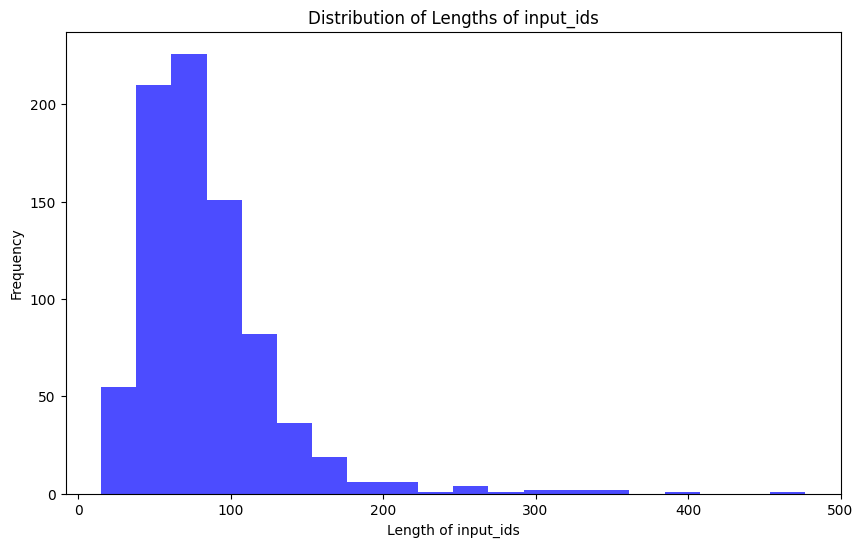

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

### Fixed Input Length Tokenization

This code ensures that all input sequences to the model are of a fixed length (512 tokens) by truncating longer sequences and padding shorter ones. This is essential for efficient processing by the model and helps in creating consistent input representations. The `generate_and_tokenize_prompt2` function handles this tokenization and formatting process, making it easier to prepare data for the model.

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

We again prepare our dataset with fixed length input sequences and plot the histogram for visualization.

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = test_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/391 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

805


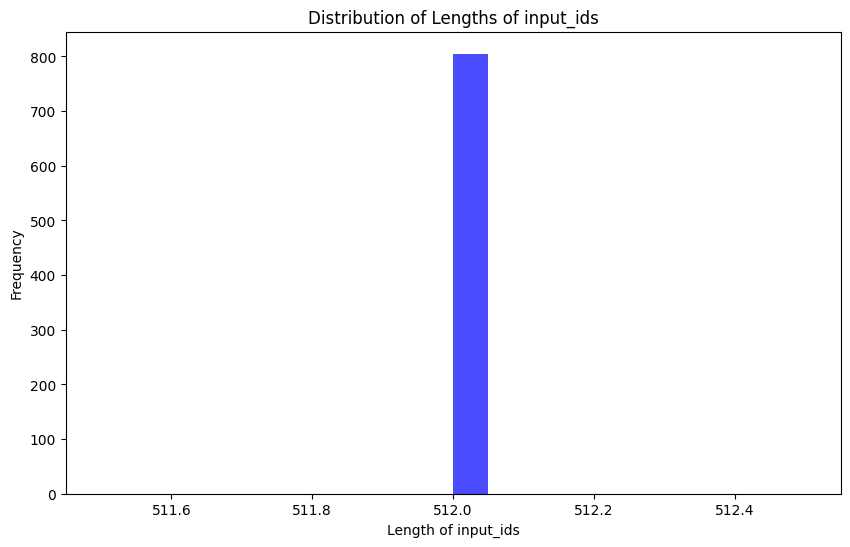

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

This function helps you understand how many parameters in your model are actively being adjusted during the training process. This is valuable information for monitoring and controlling the complexity and learning capacity of your model.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel() # When you call .numel() on a tensor, it gives you the total count of all the individual elements within that tensor, regardless of its shape or dimensions.
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_pro

In [ ]:
print_trainable_parameters(model)

trainable params: 41943040 || all params: 3800305664 || trainable%: 1.1036754331979965


### Enable Parallelism if available

This code snippet is a simple way to leverage the power of multiple GPUs if they are present in our system. By setting `is_parallelizable` and `model_parallel` to `True`, we're telling PyTorch to try and distribute the workload of your model across the available GPUs, potentially leading to faster training or inference times.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
from accelerate import Accelerator
accelerator = Accelerator()

#### Analogy for using accelerator

Imagine you have a car (model) and a mechanic (accelerator). You bring your car to the mechanic to get it ready for a race (training). The mechanic might make some adjustments or add some special components to make your car run faster and smoother on the race track (hardware). When the mechanic is done, you get your car back (model = ...), but it's now optimized for the race.

That's essentially what this line of code is doing – it's preparing the model to run more efficiently on the available hardware using the accelerate library.

In [ ]:
model = accelerator.prepare_model(model)

### Setting up Trainer

In [ ]:
import transformers
from datetime import datetime

project = "ieee-disease-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir, # The directory where training outputs (checkpoints, logs) will be saved.
        warmup_steps=2, # Number of initial steps where the learning rate is gradually increased.
        per_device_train_batch_size=4, #The batch size (number of samples processed at once) per device (GPU or CPU).
        gradient_accumulation_steps=1, # Number of steps to accumulate gradients before updating model weights. This can effectively increase batch size without requiring more memory.
        gradient_checkpointing=True, # Enables gradient checkpointing to save memory during training.
        max_steps=100,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True, # Uses bfloat16 precision, a mixed-precision training technique.
        optim="paged_adamw_8bit", # Specifies the optimizer. Here, paged_adamw_8bit is an efficient implementation of AdamW optimized for memory usage.
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),

    # A helper function for preparing batches of data.
    # In this case, DataCollatorForLanguageModeling is used for sequence modeling without masked language modeling (mlm=False).

    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
25,2.119900,1.781819
50,1.579100,1.652653
75,1.555300,1.590980
100,1.542600,1.566345


TrainOutput(global_step=100, training_loss=1.6992282485961914, metrics={'train_runtime': 9706.341, 'train_samples_per_second': 0.041, 'train_steps_per_second': 0.01, 'total_flos': 8771001743572992.0, 'train_loss': 1.6992282485961914, 'epoch': 1.0204081632653061})

### Inference
**Restart kernel before inference if got memory error.**

We run inference by loading the base model again and initializing it with the checkpoint we have saved during the training process. Since we save multiple checkpoints, we can select the best checkpoint by evaluating the training and validation loss.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.3"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-ieee-disease-finetune/checkpoint-100")

ValueError: Can't find 'adapter_config.json' at 'mistral-ieee-disease-finetune/checkpoint-300'

In [ ]:
eval_prompt = "Can you tell me the symptoms of cataract?"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))